In [233]:
from jbfg.pandas_utils  import *
import pandas as pd
import os, time
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV

# 0. 문제정의

과거 구매 이력과 현재 구매 정보를 활용하여, 구매 과거 상품 중 현재 재구매 할만한 상품을 예측하고자 한다.

In [34]:
schema = 'l2_jbbk_extnl'

In [35]:
sql1 = 'SELECT * FROM products_info';
sql2 = 'SELECT * FROM train_x_past';
sql3 = 'SELECT * FROM train_x_current';
sql4 = 'SELECT * FROM train_y';
sql5 = 'SELECT * FROM test_x_past';
sql6 = 'SELECT * FROM test_x_current';

In [188]:
df_products_info = get_df(sql1, schema);
df_train_x_past = get_df(sql2, schema);
df_train_x_current = get_df(sql3, schema);
df_train_y        = get_df(sql4, schema);
df_test_x_past    = get_df(sql5, schema);
df_test_x_current = get_df(sql6, schema);

In [39]:
df_train_x_past.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3.0,5,0,41220
1,2325772,196613,35,6,11,2.0,7,1,41220
2,642668,196613,69,2,16,2.0,11,1,4210
3,1326515,196613,61,3,19,3.0,3,1,4210
4,1437845,196613,36,3,15,4.0,16,0,4210


In [228]:
df_train_x_current.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
0,806422,41116,47,5,18,3.0,4,1
1,2146033,127113,45,1,10,7.0,24,1
2,3055498,140168,45,5,10,26.0,11,1
3,3267527,60604,52,0,16,8.0,2,1
4,3125992,136554,46,4,9,5.0,2,0


In [41]:
df_train_y.head()

,product_id
0,21709
1,21709
2,21709
3,21709
4,21709


In [175]:
# current_x 합쳐준 셋
x= pd.concat([df_train_x_current,df_train_y ], axis=1)

In [189]:
# past + current train set 생성
total =  pd.concat([df_train_x_past,x ], axis=0).reset_index(drop=True)
total

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3.0,5,0,41220
1,2325772,196613,35,6,11,2.0,7,1,41220
2,642668,196613,69,2,16,2.0,11,1,4210
3,1326515,196613,61,3,19,3.0,3,1,4210
4,1437845,196613,36,3,15,4.0,16,0,4210
...,...,...,...,...,...,...,...,...,...
1278391,3184000,174046,100,5,7,2.0,12,1,24852
1278392,1754722,6710,100,5,11,3.0,21,1,24852
1278393,1076973,150840,100,0,13,0.0,18,1,24852
1278394,1247049,99707,100,1,13,3.0,6,1,24852


In [190]:
total_test =  pd.concat([df_test_x_past,df_test_x_current ], axis=0).reset_index(drop=True)
total_test

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,117004,186630,37,4,11,3.0,12,1,21709
1,128658,186630,20,2,10,6.0,4,1,21709
2,165882,186630,56,3,15,5.0,10,1,21709
3,180165,186630,17,1,16,4.0,4,1,21709
4,394948,186630,46,5,11,7.0,7,1,21709
...,...,...,...,...,...,...,...,...,...
558043,2047884,57077,46,5,15,8.0,2,1,NaN
558044,567625,83592,43,4,12,0.0,1,1,NaN
558045,596442,157740,49,6,10,3.0,2,1,NaN
558046,671102,92043,43,4,10,10.0,1,1,NaN


## 1.1 데이터 분포 확인 및 전처리

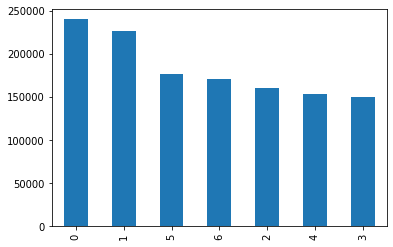

In [177]:
total['week_day'].value_counts().plot(kind='bar') 

일요일이 가장 구매가 많음

In [178]:
# 구매가 많은 0,1 을 각각 8,7로 치환해줌
total['week_day'] = total['week_day'].replace({'0':'8'})
total['week_day'] = total['week_day'].replace({'1':'7'})

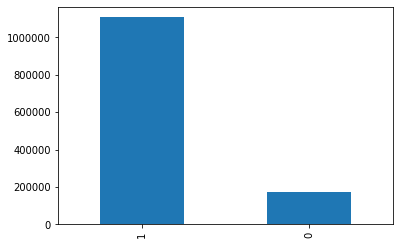

In [179]:
total['is_reordered'].value_counts().plot(kind='bar')

## 1.2 결측치 확인

In [180]:
pd.isna(total).sum() 

order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
product_id        0
dtype: int64

In [183]:
total['week_day'].value_counts()#sort_values(ascending=False)

8    240026
7    225969
5    177221
6    171038
2    159943
4    153835
3    150364
Name: week_day, dtype: int64

In [181]:
total['is_reordered'].value_counts()#sort_values(ascending=False)

1    1106761
0     171635
Name: is_reordered, dtype: int64

In [182]:
total['order_number'].value_counts()#sort_values(ascending=False)

1      21686
43     21086
44     20695
42     20693
40     20494
       ...  
96      2265
97      2063
100     2060
98      2019
99      1881
Name: order_number, Length: 100, dtype: int64

In [184]:
total['order_interval'].value_counts()

7.0     169910
4.0     161650
3.0     160619
5.0     140710
6.0     136955
2.0     124350
8.0      77736
1.0      71951
9.0      40150
10.0     27188
0.0      27162
         21686
11.0     20177
12.0     16725
14.0     15910
13.0     15088
15.0      9707
16.0      6127
30.0      5906
17.0      4618
18.0      3855
21.0      3605
20.0      3256
19.0      3189
22.0      2292
23.0      1490
24.0      1405
25.0      1253
27.0      1048
28.0       992
26.0       924
29.0       762
Name: order_interval, dtype: int64

## 1.3 불필요한 칼럼 제거

In [185]:
total1 =total.drop(['order_id'], axis=1)
total1

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,196613,15,7,9,3.0,5,0,41220
1,196613,35,6,11,2.0,7,1,41220
2,196613,69,2,16,2.0,11,1,4210
3,196613,61,3,19,3.0,3,1,4210
4,196613,36,3,15,4.0,16,0,4210
...,...,...,...,...,...,...,...,...
1278391,174046,100,5,7,2.0,12,1,24852
1278392,6710,100,5,11,3.0,21,1,24852
1278393,150840,100,8,13,0.0,18,1,24852
1278394,99707,100,7,13,3.0,6,1,24852


In [191]:
total_test1 = total_test.drop(['order_id'], axis=1)

In [192]:
total2 = total1.sort_values(by=[total1.columns[0],total1.columns[1]], ascending=True)
total2.reset_index(drop=True)

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,10000,1,8,11,,12,0,15290
1,10000,1,8,11,,3,0,5077
2,10000,1,8,11,,8,0,26604
3,10000,1,8,11,,7,0,27104
4,10000,1,8,11,,10,0,22935
...,...,...,...,...,...,...,...,...
1278391,99901,8,3,13,5.0,2,1,49235
1278392,99901,8,3,13,5.0,4,0,27966
1278393,99901,9,4,17,8.0,4,1,34969
1278394,99901,9,4,17,8.0,1,1,49235


In [193]:
total_test2 = total_test1.sort_values(by=[total_test1.columns[0],total_test1.columns[1]], ascending=True)
total_test2.reset_index(drop=True)

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,100041,1,6,16,,11,0,34358
1,100041,1,6,16,,21,0,33731
2,100041,1,6,16,,17,0,27086
3,100041,1,6,16,,14,0,39275
4,100041,1,6,16,,5,0,27966
...,...,...,...,...,...,...,...,...
558043,99990,8,5,14,8.0,3,1,42265
558044,99990,8,5,14,8.0,7,0,28204
558045,99990,8,5,14,8.0,8,1,16797
558046,99990,9,5,13,7.0,3,1,24184


In [194]:
last_order_index = total2.drop_duplicates(['cstno'], keep = 'last')[['cstno','order_number']].set_index(['cstno','order_number']).index
last_order_index

MultiIndex([( '10000',  '9'),
            ('100001',  '9'),
            ('100046',  '9'),
            ('100071',  '9'),
            ('100108',  '9'),
            ('100116',  '8'),
            ('100142', '99'),
            ('100173',  '9'),
            ('100182',  '9'),
            ('100198',  '9'),
            ...
            ( '99707', '99'),
            ( '99727', '99'),
            ( '99735',  '9'),
            ( '99753', '99'),
            ( '99805', '99'),
            (  '9981',  '9'),
            ( '99829',  '9'),
            ( '99887', '92'),
            ( '99894',  '9'),
            ( '99901',  '9')],
           names=['cstno', 'order_number'], length=5859)

In [195]:
last_order_index = total_test2.drop_duplicates(['cstno'], keep = 'last')[['cstno','order_number']].set_index(['cstno','order_number']).index
last_order_index

MultiIndex([('100041', '9'),
            ('100103', '8'),
            ('100165', '9'),
            ('100270', '9'),
            ('100359', '9'),
            ('100361', '8'),
            ('100414', '9'),
            ('100508', '9'),
            ('100540', '9'),
            ('100675', '9'),
            ...
            ( '99614', '9'),
            ( '99757', '6'),
            ( '99786', '7'),
            ( '99817', '8'),
            ( '99845', '9'),
            ( '99897', '9'),
            (   '999', '9'),
            ( '99915', '9'),
            ( '99963', '9'),
            ( '99990', '9')],
           names=['cstno', 'order_number'], length=4141)

In [23]:
Y_data = total2[total2.set_index(['cstno','order_number']).index.isin(last_order_index)]
Y_data 

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
423355,10000,9,5,15,5.0,4,1,35951
423421,10000,9,5,15,5.0,9,1,26604
423513,10000,9,5,15,5.0,1,1,47766
423556,10000,9,5,15,5.0,10,1,21137
73938,100001,9,0,10,4.0,2,1,3957
...,...,...,...,...,...,...,...,...
72015,99894,9,5,22,4.0,7,1,44632
72039,99894,9,5,22,4.0,18,1,21137
72390,99901,9,4,17,8.0,4,1,34969
72446,99901,9,4,17,8.0,1,1,49235


In [148]:
Y_test_data = total_test2[total_test2.set_index(['cstno','order_number']).index.isin(last_order_index)]
Y_test_data 

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
36229,100041,9,0,15,2.0,8,1,34358
222107,100041,9,0,15,2.0,5,1,27086
500572,100041,9,0,15,2.0,9,1,13176
39773,100103,8,1,9,9.0,2,1,43122
38510,100165,9,0,8,2.0,3,1,23909
...,...,...,...,...,...,...,...,...
524730,99915,9,1,14,8.0,3,1,24852
141889,99963,9,4,8,1.0,8,0,24184
207023,99963,9,4,8,1.0,7,0,46979
139561,99990,9,5,13,7.0,3,1,24184


In [24]:
Y_data = Y_data.reset_index(drop=True)
Y_data

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,10000,9,5,15,5.0,4,1,35951
1,10000,9,5,15,5.0,9,1,26604
2,10000,9,5,15,5.0,1,1,47766
3,10000,9,5,15,5.0,10,1,21137
4,100001,9,0,10,4.0,2,1,3957
...,...,...,...,...,...,...,...,...
21318,99894,9,5,22,4.0,7,1,44632
21319,99894,9,5,22,4.0,18,1,21137
21320,99901,9,4,17,8.0,4,1,34969
21321,99901,9,4,17,8.0,1,1,49235


In [25]:
X_data = total2.loc[~total2.index.isin(Y_data.index),:].reset_index(drop=True)
X_data

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,10000,1,0,11,,12,0,15290
1,10000,1,0,11,,3,0,5077
2,10000,1,0,11,,8,0,26604
3,10000,1,0,11,,7,0,27104
4,10000,1,0,11,,10,0,22935
...,...,...,...,...,...,...,...,...
1257068,99901,8,3,13,5.0,2,1,49235
1257069,99901,8,3,13,5.0,4,0,27966
1257070,99901,9,4,17,8.0,4,1,34969
1257071,99901,9,4,17,8.0,1,1,49235


# 2. 학습을 위한 각 고객 상품별 데이터 정합

  ## 2.1 각 고객 상품별 총 구매 수 및 target_y 생성

In [26]:
#cstno별 상품별 count
X_data_total = X_data.groupby(['cstno','product_id']).count()['order_number'].reset_index().pivot(index='cstno', columns='product_id', values='order_number').fillna(0)
Y_data_total = Y_data.groupby(['cstno','product_id']).count()['order_number'].reset_index().pivot(index='cstno', columns='product_id', values='order_number').fillna(0)
Y_data_total[Y_data_total>1]=1
Y_data_total # 구매여부 1,0 으로 세팅

product_id,10749,11520,12341,13176,15290,16759,16797,17794,18465,19057,...,5785,5876,7781,8174,8277,8424,8518,9076,9387,9839
cstno,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99829,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99887,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
#cstno별 상품별 count ==> test 데이터셋도 형테 만들어주기
df_test_x_past_1 = df_test_x_past.groupby(['cstno','product_id']).count()['order_number'].reset_index().pivot(index='cstno', columns='product_id', values='order_number').fillna(0)
df_test_x_past_1

product_id,10749,11520,12341,13176,15290,16759,16797,17794,18465,19057,...,5785,5876,7781,8174,8277,8424,8518,9076,9387,9839
cstno,,,,,,,,,,,,,,,,,,,,,
100041,0.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100103,8.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100165,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
100270,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
100359,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99897,0.0,0.0,0.0,11.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0,0.0
999,9.0,12.0,0.0,15.0,16.0,0.0,6.0,0.0,4.0,0.0,...,23.0,0.0,6.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
99915,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,0.0


  ## 2.2 각 고객 상품별 요일, 시간, 상품의 순번, 재구매여부 평균값 생성

In [28]:
X_data_mean = X_data.astype({'week_day':'float', 'order_hour':'float',  'add_order':'float', 'is_reordered':'float'}).groupby(['cstno','product_id']).mean().loc[:,'week_day':'is_reordered'].reset_index().pivot(index='cstno', columns='product_id').fillna(0).round()
X_data_mean

week_day                                                        \
product_id    10749 11520 12341 13176 15290 16759 16797 17794 18465 19057   
cstno                                                                       
10000           2.0   3.0   0.0   2.0   1.0   0.0   0.0   2.0   4.0   0.0   
100001          4.0   0.0   0.0   3.0   2.0   0.0   0.0   3.0   2.0   0.0   
100046          0.0   0.0   0.0   3.0   0.0   0.0   4.0   3.0   0.0   2.0   
100071          2.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
100108          0.0   2.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   3.0   
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
9981            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
99829           0.0   0.0   0.0   6.0   0.0   4.0   0.0   2.0   0.0   0.0   
99887           0.0   0.0   0.0   0.0   0.0   3.0   0.0   0.0   0.0   4.0   
99894           0.0   0.0   4.0   0.0   0.0   0.0   3.0   0.0   0.0   0.0   
99901           0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   

            ... is_reordered                                               
product_id  ...         5785 5876 7781 8174 8277 8424 8518 9076 9387 9839  
cstno       ...                                                            
10000       ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
100001      ...          0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  
100046      ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
100071      ...          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
100108      ...          0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
...         ...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
9981        ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99829       ...          0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
99887       ...          0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  
99894       ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99901       ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  

[5859 rows x 400 columns]

In [46]:
df_test_x_past_mean = df_test_x_past.astype({'week_day':'float', 'order_hour':'float',  'add_order':'float', 'is_reordered':'float'}).groupby(['cstno','product_id']).mean().loc[:,'week_day':'is_reordered'].reset_index().pivot(index='cstno', columns='product_id').fillna(0).round()
df_test_x_past_mean

week_day                                                        \
product_id    10749 11520 12341 13176 15290 16759 16797 17794 18465 19057   
cstno                                                                       
100041          0.0   0.0   0.0   4.0   0.0   0.0   0.0   2.0   0.0   0.0   
100103          2.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   4.0   
100165          0.0   0.0   0.0   0.0   0.0   0.0   6.0   1.0   0.0   0.0   
100270          0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   
100359          0.0   0.0   0.0   4.0   0.0   5.0   2.0   2.0   0.0   0.0   
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
99897           0.0   0.0   0.0   3.0   0.0   0.0   0.0   2.0   0.0   0.0   
999             3.0   3.0   0.0   2.0   3.0   0.0   4.0   0.0   3.0   0.0   
99915           0.0   0.0   0.0   3.0   0.0   0.0   2.0   0.0   0.0   0.0   
99963           0.0   0.0   0.0   3.0   4.0   0.0   4.0   4.0   0.0   0.0   
99990           0.0   0.0   0.0   5.0   0.0   0.0   3.0   0.0   0.0   0.0   

            ... is_reordered                                               
product_id  ...         5785 5876 7781 8174 8277 8424 8518 9076 9387 9839  
cstno       ...                                                            
100041      ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
100103      ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
100165      ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
100270      ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
100359      ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
...         ...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
99897       ...          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
999         ...          1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
99915       ...          0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
99963       ...          0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
99990       ...          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[4141 rows x 400 columns]

In [29]:
X_data_total_f = pd.concat([X_data_total,X_data_mean], axis=1)
X_data_total_f

,10749,11520,12341,13176,15290,16759,16797,17794,18465,19057,...,"(is_reordered, 5785)","(is_reordered, 5876)","(is_reordered, 7781)","(is_reordered, 8174)","(is_reordered, 8277)","(is_reordered, 8424)","(is_reordered, 8518)","(is_reordered, 9076)","(is_reordered, 9387)","(is_reordered, 9839)"
cstno,,,,,,,,,,,,,,,,,,,,,
10000,15.0,15.0,0.0,6.0,5.0,1.0,0.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100001,7.0,0.0,0.0,42.0,1.0,0.0,0.0,7.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
100046,0.0,0.0,0.0,2.0,0.0,0.0,2.0,12.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100071,1.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100108,0.0,32.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99829,4.0,0.0,0.0,1.0,0.0,10.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
99887,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,9.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [47]:
df_test_x_total_f = pd.concat([df_test_x_past_1,df_test_x_past_mean], axis=1)
df_test_x_total_f

,10749,11520,12341,13176,15290,16759,16797,17794,18465,19057,...,"(is_reordered, 5785)","(is_reordered, 5876)","(is_reordered, 7781)","(is_reordered, 8174)","(is_reordered, 8277)","(is_reordered, 8424)","(is_reordered, 8518)","(is_reordered, 9076)","(is_reordered, 9387)","(is_reordered, 9839)"
cstno,,,,,,,,,,,,,,,,,,,,,
100041,0.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100103,8.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100165,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100270,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100359,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99897,0.0,0.0,0.0,11.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
999,9.0,12.0,0.0,15.0,16.0,0.0,6.0,0.0,4.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99915,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 3. 학습모델 생성

## 3.1 모델성능비교
# xgboost vs lgb
성능상으로 xgboost와 큰 차이가 없음.
하지만 LightGBM의 가장 큰 장점은 xgboost보다 학습에 걸리는 시간이 훨씬 적다는 점이다.
또한 메모리 사용량도 상대적으로 적고 기능상의 다양성도 많아 효율적으로 사용이 가능함.
따라서 예측대상인 y의 차원수가 100개 이상이고, 데이터 사이즈가 크기 때문에 튜닝을 효율적으로 할 수 있으려면 좋은 성능을 보장하면서 학습이 빠른 lgb로 선택하였음.

In [ ]:
# xgboost 학습모델 생성

start = time.time()
xgb_model = XGBClassifier(random_state=20221020, n_jobs=-1, verbose=3)
param_grid = {'n_estimators' : list(range(100,1000,100)),
               # 'max_depth' : list(range(5,15,5)),
            #  'learning_rate' : [0.01]
              'nthread' : [-1]}
xgb_model = GridSearchCV(estimator=xgb_model, param_grid = param_grid, n_jobs=None)
xgb_model = MultiOutputClassifier(xgb_model,n_jobs=-1)
xgb_model = xgb_model.fit(X_data_total_f, Y_data_total, verbose=True)



with open('xgb_model.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)
    
end = time.time()
print(f"{end - start : 5f} sec")


In [30]:
# lgb 학습모델 생성

start = time.time()
lgb_model_2 = lgb.LGBMClassifier(random_state=20221020, n_jobs=-1, verbose=3)
param_grid = {'n_estimators' : list(range(100,1000,100)),
               # 'max_depth' : list(range(5,15,5)),
            #  'learning_rate' : [0.01]
              'nthread' : [-1]}
lgb_model_2 = GridSearchCV(estimator=lgb_model_2, param_grid = param_grid, n_jobs=None)
lgb_model_2 = MultiOutputClassifier(lgb_model_2,n_jobs=-1)
lgb_model_2 = lgb_model_2.fit(X_data_total_f, Y_data_total, verbose=True)



with open('lgb_model_2.pickle', 'wb') as f:
    pickle.dump(lgb_model_2, f)
    
end = time.time()
print(f"{end - start : 5f} sec")


 15487.206990 sec


 ## 3.2 lgb 파라미터 튜닝 진행
   ## 최종 학습 모델

In [134]:
# 학습모델 생성

start = time.time()
lgb_model_1 = lgb.LGBMClassifier(random_state=20221020, n_jobs=-1, verbose=3)
param_grid = {'n_estimators' : list(range(100,1000,100)),
                'max_depth' : list(range(5,15,5)),
              'learning_rate' : [0.01],
              'nthread' : [-1]}
lgb_model_1 = GridSearchCV(estimator=lgb_model_1, param_grid = param_grid, n_jobs=None)
lgb_model_1 = MultiOutputClassifier(lgb_model_1,n_jobs=-1)
lgb_model_1 = lgb_model_1.fit(X_data_total_f, Y_data_total, verbose=True)



with open('lgb_model_1.pickle', 'wb') as f:
    pickle.dump(lgb_model_1, f)
    
end = time.time()
print(f"{end - start : 5f} sec")


 127032.546489 sec


In [203]:
with open("lgb_model_1.pickle","rb") as f : lgb_model_1 = pickle.load(f)

# 4. 학습한 모델 기반 test_y 생성을 통한 문제 해결

In [229]:
# 각 cstno 별 class의 0 또는 1 확률을 출력
predict_result = lgb_model_1.predict_proba(df_test_x_total_f)

In [208]:
cstno = df_test_x_total_f.index
cstno

Index(['100041', '100103', '100165', '100270', '100359', '100361', '100414',
       '100508', '100540', '100675',
       ...
       '99614', '99757', '99786', '99817', '99845', '99897', '999', '99915',
       '99963', '99990'],
      dtype='object', name='cstno', length=4141)

In [209]:
product_id = X_data_total.columns
product_id

Index(['10749', '11520', '12341', '13176', '15290', '16759', '16797', '17794',
       '18465', '19057', '196', '19660', '20114', '20995', '21137', '21616',
       '21709', '21903', '21938', '22035', '22825', '22935', '23909', '24184',
       '24838', '24852', '24964', '25890', '26209', '26604', '27086', '27104',
       '27156', '27344', '27521', '27845', '27966', '28199', '28204', '28842',
       '28985', '29487', '30391', '30489', '31506', '31717', '33000', '33198',
       '33731', '34126', '34358', '34969', '35221', '35951', '37646', '38689',
       '39275', '3957', '39877', '39928', '40706', '41220', '41787', '41950',
       '4210', '42265', '42736', '43122', '43352', '43961', '44142', '44359',
       '44632', '45007', '45066', '4605', '46667', '46906', '46979', '47144',
       '47209', '47626', '47766', '4799', '48679', '4920', '49235', '49683',
       '5077', '5450', '5785', '5876', '7781', '8174', '8277', '8424', '8518',
       '9076', '9387', '9839'],
      dtype='object', name=

In [210]:
# 위 확률로 나온 리스트를 통해 cstno,product_id 형태의 확률를 갖는 데이터 프레임 생성
recommand_result = pd.DataFrame()
for product in predict_result:
    temp = []
    for person in product :
        temp.append(person[1])
    recommand_result = pd.concat([recommand_result, pd.DataFrame([temp])], axis=0)

In [211]:
recommand_result = recommand_result.T

In [212]:
recommand_result

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.003728,0.000014,0.003024,0.239933,0.000709,0.006561,0.006006,0.006550,0.006467,0.017328,...,0.000478,0.011052,0.001535,0.009046,0.006877,0.007121,0.012696,0.000132,0.000247,0.007100
1,0.061579,0.000029,0.003024,0.296965,0.000531,0.005380,0.006006,0.002197,0.006467,0.020774,...,0.000352,0.008652,0.000471,0.009046,0.006877,0.007121,0.012622,0.000131,0.000505,0.007100
2,0.002259,0.000010,0.003024,0.025567,0.000711,0.005521,0.009600,0.002728,0.006467,0.017328,...,0.000411,0.008652,0.000221,0.010898,0.006877,0.007705,0.012155,0.007465,0.000620,0.007100
3,0.002174,0.000015,0.003024,0.025567,0.000546,0.005380,0.587395,0.001716,0.006467,0.017328,...,0.000366,0.008652,0.000272,0.009046,0.006877,0.007121,0.012228,0.003975,0.000227,0.007100
4,0.002333,0.000011,0.003024,0.026224,0.000416,0.010193,0.011843,0.002552,0.006467,0.017328,...,0.000508,0.011182,0.000377,0.010898,0.006877,0.007121,0.012696,0.134836,0.000345,0.007206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4136,0.005117,0.000016,0.003019,0.193078,0.000450,0.005380,0.006104,0.053036,0.006467,0.017328,...,0.000357,0.009454,0.000229,0.009046,0.016102,0.010487,0.118232,0.000128,0.000402,0.007100
4137,0.037996,0.056515,0.003024,0.184007,0.113268,0.015410,0.059138,0.002469,0.033547,0.017328,...,0.578746,0.013642,0.040071,0.009700,0.007834,0.010817,0.012228,0.002246,0.000220,0.007100
4138,0.005288,0.000008,0.003024,0.026380,0.000451,0.010115,0.054906,0.004575,0.006467,0.017328,...,0.000374,0.008652,0.001195,0.009046,0.006877,0.032890,0.012622,0.000712,0.000411,0.007801
4139,0.002165,0.000012,0.003024,0.174120,0.186603,0.005380,0.044611,0.021518,0.006467,0.017328,...,0.000302,0.008652,0.000610,0.009046,0.006877,0.081849,0.013105,0.001469,0.000290,0.007100


In [213]:
recommand_result.columns = product_id

In [214]:
recommand_result.index = cstno

In [215]:
recommand_result

product_id,10749,11520,12341,13176,15290,16759,16797,17794,18465,19057,...,5785,5876,7781,8174,8277,8424,8518,9076,9387,9839
cstno,,,,,,,,,,,,,,,,,,,,,
100041,0.003728,0.000014,0.003024,0.239933,0.000709,0.006561,0.006006,0.006550,0.006467,0.017328,...,0.000478,0.011052,0.001535,0.009046,0.006877,0.007121,0.012696,0.000132,0.000247,0.007100
100103,0.061579,0.000029,0.003024,0.296965,0.000531,0.005380,0.006006,0.002197,0.006467,0.020774,...,0.000352,0.008652,0.000471,0.009046,0.006877,0.007121,0.012622,0.000131,0.000505,0.007100
100165,0.002259,0.000010,0.003024,0.025567,0.000711,0.005521,0.009600,0.002728,0.006467,0.017328,...,0.000411,0.008652,0.000221,0.010898,0.006877,0.007705,0.012155,0.007465,0.000620,0.007100
100270,0.002174,0.000015,0.003024,0.025567,0.000546,0.005380,0.587395,0.001716,0.006467,0.017328,...,0.000366,0.008652,0.000272,0.009046,0.006877,0.007121,0.012228,0.003975,0.000227,0.007100
100359,0.002333,0.000011,0.003024,0.026224,0.000416,0.010193,0.011843,0.002552,0.006467,0.017328,...,0.000508,0.011182,0.000377,0.010898,0.006877,0.007121,0.012696,0.134836,0.000345,0.007206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99897,0.005117,0.000016,0.003019,0.193078,0.000450,0.005380,0.006104,0.053036,0.006467,0.017328,...,0.000357,0.009454,0.000229,0.009046,0.016102,0.010487,0.118232,0.000128,0.000402,0.007100
999,0.037996,0.056515,0.003024,0.184007,0.113268,0.015410,0.059138,0.002469,0.033547,0.017328,...,0.578746,0.013642,0.040071,0.009700,0.007834,0.010817,0.012228,0.002246,0.000220,0.007100
99915,0.005288,0.000008,0.003024,0.026380,0.000451,0.010115,0.054906,0.004575,0.006467,0.017328,...,0.000374,0.008652,0.001195,0.009046,0.006877,0.032890,0.012622,0.000712,0.000411,0.007801


In [230]:
# 위에서 생성된 데이터프레임을 통해 cstno별 추천 확률이 높은 상품 순으로 정렬하여 랭킹을 매기는 과정 
# 랭킹이 1위일수록 해당 유저의 각 상품들 중 1순위로 구매할 확률이 높은 상품임 
recommand_result3 = pd.melt(recommand_result2, id_vars=['cstno']).sort_values(by=['cstno','value'], ascending = [True, False]).reset_index(drop=True)

In [217]:
recommand_result3.columns = ['cstno','product_id','prob'] 
recommand_result3

,cstno,product_id,prob
0,100041,21903,8.366974e-01
1,100041,13176,2.668874e-01
2,100041,21137,1.690236e-01
3,100041,34358,1.880132e-02
4,100041,26209,1.408664e-03
...,...,...,...
414095,99990,24838,6.477466e-10
414096,99990,25890,6.166032e-10
414097,99990,34126,5.608417e-10
414098,99990,38689,5.243852e-10


In [218]:
recommand_result3['prob'] = recommand_result3['prob'].round(2) 

In [219]:
rank = recommand_result3.groupby(['cstno']).apply(lambda x : list(range(len(x)))).reset_index().explode(0).reset_index(drop=True) 

In [220]:
rank.columns = ['cstno','rank'] 
rank['rank'] = rank['rank'] +1
recommand_result4 = pd.concat([rank,recommand_result3[['product_id','prob']]],axis=1) 

In [221]:
recommand_result4

,cstno,rank,product_id,prob
0,100041,1,21903,0.84
1,100041,2,13176,0.27
2,100041,3,21137,0.17
3,100041,4,34358,0.02
4,100041,5,26209,0.00
...,...,...,...,...
414095,99990,96,24838,0.00
414096,99990,97,25890,0.00
414097,99990,98,34126,0.00
414098,99990,99,38689,0.00


In [226]:
# test_x와 예측상품의 구입 순서(랭킹)이 포함된 recommand_result를  merge하는 과정 
final_result= pd.merge(df_test_x_current[['cstno','add_order']], recommand_result4.astype({'rank':'str'})[['cstno','rank','product_id']], left_on = ['cstno','add_order'], right_on= ['cstno','rank'],how='inner') 
final_result = final_result.drop(['rank','cstno','add_order'],axis=1)          
final_result

,product_id
0,19057
1,40706
2,47766
3,39928
4,47209
...,...
16121,9387
16122,24852
16123,24852
16124,24852


### test_y csv로 저장

In [227]:
final_result.to_csv('test_y.csv')